# Death on Two Legs, an Optimal Control Simulation
Addison Powell, Jared Smith, Tyler Christensen, William Lewis

### Abstract
In this project we model the movement of a bipedal robot across a flat surface utilizing optimal control. Our model considers the  biped as a system with two legs acting as double-pendulums. The objective is to minimize the distance between the robot's final position (state) and a specified destination. After setting up a system of ODEs, we utilize both numerical and analytical solutions to model the robot. The project was able to successfully model bringing the robot to a standing position, but further work is needed on the state equations relating to vertical position for modeling walking.

## 1 Background

Our project is modelling how to move a biped across terrain. Given a point of connection and 2 legs acting as double-pendulums, we attempt to minimize the distance between the robots final state and a given point using the angles of each leg as control.

Prior work on similar problems with an emphasis on the underlying physics. Such projects include Koch et. al's work with walking gait control$^3$, Friston's work with motor functions$^1$, and Weng et. al's work with muskulokeletal models$^4$. We are attempting a model which has been abstracted from real-world physics, to determine if similar movement can be mathematically motivated.

## 2 Modeling
### 2.1 Initial Modeling
In order to model the robot's movement, we are treating the legs as double pendulums. A $\theta$ parameter represents the angles of the "thigh" pendulums, and a $\phi$ parameter represents the angle of the "calf" pendulums. Our state $\vec{x}$, represents the position of the top of the legs where they connect (see figure below).

<p align="center">
  <img src="mediafolder/jaadlity.png" alt="Stick Fig" width="400"/>
</p>

Our model tries to minimize the amount the legs move, and the time spent moving for $\vec{x}$ to reach a final state. We constrain our control to possible angles similar to the standard human range of motion:

$$-10\degree\leq\theta_i \leq90\degree$$
$$-90\degree+\theta_i\leq\phi_i\leq0\degree+\theta_i$$

In the interest of generating a problem that can be solved within the confines of this project, we elected to abstract it from real world physics by attempting to simulate similar behavior mathematically. In other words, we do not consider physical features such as friction or mass but instead have rules such as the foot being on the ground should fix it in place or neither foot on the ground causes a negative velocity in the y direction.

Given the constraints explained above, we have devised the following cost functional, with our desired vertical position as $y^*$.

$$\int_0^{t_f}(\alpha_3 u_1)^2 + (\alpha_3 u_2)^2 + (\alpha_4 u_3)^2 + (\alpha_4 u_4)^2 + (\alpha(y - y^*)^4 dt$$

Since our control is defined on a compact set the optimal control might end up being a bang-bang solution. However, at each discrete timestep we want to avoid extreme motion in the legs. To achieve this we normalize the control by the desired maximum amount of motion at a timestep (such as 5 degrees of change from one frame to another) and then square this term leading to the $(\alpha_3 u_1)^2$ and similar terms in the cost function.

<p align="center">
  <img src="mediafolder/CostFig.png" alt="Stick Fig" width="400"/>
</p>

Then, in order to define our state equation we start with the following:

$$x_i' = l_2(\phi_i')\cos\phi_i + l1(\theta_i')\cos\theta_i$$
$$y_i' = l_2(\phi_i')\sin\phi_i + l_1(\theta_i')\sin\theta_i$$

This comes from finding the position of the top point of a single double pendulum and then taking the derivative with respect to time to try and find the force it exerts on the point $\vec{x}$. Also note the derivative terms--we handle these by adding them to our control, making it 8-dimensional. 

From here we then define the following condition:

\begin{equation*}c_i = 
\begin{cases}
\text{True} & y - (l_1\cos(\theta_i) + l_2\cos(\phi_i)) \leq 0 \\
\text{False} & \text{otherwise}
\end{cases}
\end{equation*}

This condition is supposed to tell use whether or not a foot (end of a double pendulum) is on the ground ($y=0$). Therefore, our state equation comes out to

\begin{align*}
\vec{x}' &= [x', y']^T\\

x' &= \begin{cases}
x_1' + x_2' & c_1\text{ and }c_2 \\
x_1' & c_1 \text{ and not } c_2 \\
x_2' & c_2 \text{ and not } c_1 \\
0 & \text{otherwise}
\end{cases}\\

y' &= \begin{cases}
y_1' + y_2' & c_1\text{ and }c_2 \\
y_1' & c_1 \text{ and not } c_2 \\
y_2' & c_2 \text{ and not } c_1 \\
-\alpha_2 & \text{otherwise}
\end{cases}

\end{align*}

### 2.2 Deriving a System of ODEs
Using Pontyagrin's Maximum Principle modified with KKT conditions for our inequality constraings we get the following modified lagrangian:

\begin{align*}
\mathscr{L} &= p_1\cdot x' + p_2\cdot y' - (\alpha_3 u_1)^2 - (\alpha_3 u_2)^2 - (\alpha_4 u_3)^2 - (\alpha_4 u_4)^2 - (\alpha(y - y^*))^4 \\
&- \mu_1(\phi_1 - \theta_1) - \mu_2(-\frac{\pi}{2} + \theta_1 - \phi_1) - \mu_3(-\frac{\pi}{18} - \theta_1) - \mu_4(-\frac{\pi}{2} + \theta_1) \\
&- \mu_5(\phi_2 - \theta_2) - \mu_6(-\frac{\pi}{2} + \theta_2 - \phi_2) - \mu_7(-\frac{\pi}{18} - \theta_2) - \mu_8(-\frac{\pi}{2} + \theta_2) \\
\end{align*}

This then gives us the costate evolution of:

\begin{align*}
\vec{p'} &= [-\frac{DL}{Dx},\ -\frac{DL}{Dy}] = [0, \ 4(x_1(y-y^*)^3)]\\
\vec{p'}(t_f) &= -\frac{\Delta\phi}{\Delta\vec{x}(t_f)} = \vec{0}
\end{align*}

From $\frac{D\mathscr{L}}{D\vec{u}} = \vec{0}$, we get the following derivatives:

$$\vec{u} = (\theta_1,\theta_2,\phi_1,\phi_2,\theta_1',\theta_2',\phi_1',\phi_2')\$$

$$\frac{D\mathscr{L}}{D\theta_1} = -2\alpha_3\theta_1 + \mu_1 - \mu_2 + \mu_3 - \mu_4 + p_1\left\{\begin{array}{lr}
    -\ell_1\theta_1'\sin\theta_1 & \text{if cond 1} \\
    0 & \text{else}
\end{array}\right\} + p_2\left\{\begin{array}{lr}
    \ell_1\theta_1'\cos\theta_1 & \text{if cond 1} \\
    0 & \text{else}
\end{array}\right\} = 0$$

$$\frac{D\mathscr{L}}{D\theta_2} = -2\alpha_3\theta_2 + \mu_5 - \mu_6 + \mu_7 - \mu_8 + p_1\left\{\begin{array}{lr}
    -\ell_1\theta_2'\sin\theta_2 & \text{if cond 2} \\
    0 & \text{else}
\end{array}\right\} + p_2\left\{\begin{array}{lr}
    \ell_1\theta_2'\cos\theta_2 & \text{if cond 2} \\
    0 & \text{else}
\end{array}\right\} = 0$$

$$\frac{D\mathscr{L}}{D\phi_1} = -2\alpha_4\phi_1 - \mu_1 + \mu_2 + p_1\left\{\begin{array}{lr}
    -\ell_2\phi_1'\sin\phi_1 & \text{if cond 1} \\
    0 & \text{else}
\end{array}\right\} + p_2\left\{\begin{array}{lr}
    \ell_2\phi_1'\cos\phi_1 & \text{if cond 1} \\
    0 & \text{else}
\end{array}\right\} = 0$$

$$\frac{D\mathscr{L}}{D\phi_2} = -2\alpha_4\phi_2 - \mu_5 + \mu_6 + p_1\left\{\begin{array}{lr}
    -\ell_2\phi_2'\sin\phi_2 & \text{if cond 2} \\
    0 & \text{else}
\end{array}\right\} + p_2\left\{\begin{array}{lr}
    \ell_2\phi_2'\cos\phi_2 & \text{if cond 2} \\
    0 & \text{else}
\end{array}\right\} = 0$$

$$\frac{D\mathscr{L}}{D\theta_1'} = p_1\left\{\begin{array}{lr}
    \ell_1\cos\theta_1 & \text{if cond 1} \\
    0 & \text{else}
\end{array}\right\} + p_2\left\{\begin{array}{lr}
    \ell_1\sin\theta_1 & \text{if cond 1} \\
    0 & \text{else}
\end{array}\right\} = 0$$

$$\frac{D\mathscr{L}}{D\theta_2'} = p_1\left\{\begin{array}{lr}
    \ell_1\cos\theta_2 & \text{if cond 2} \\
    0 & \text{else}
\end{array}\right\} + p_2\left\{\begin{array}{lr}
    \ell_1\sin\theta_2 & \text{if cond 2} \\
    0 & \text{else}
\end{array}\right\} = 0$$

$$\frac{D\mathscr{L}}{D\phi_1'} = p_1\left\{\begin{array}{lr}
    \ell_2\cos\phi_1 & \text{if cond 1} \\
    0 & \text{else}
\end{array}\right\} + p_2\left\{\begin{array}{lr}
    \ell_2\sin\phi_1 & \text{if cond 1} \\
    0 & \text{else}
\end{array}\right\} = 0$$

$$\frac{D\mathscr{L}}{D\phi_2'} = p_1\left\{\begin{array}{lr}
    \ell_2\cos\phi_2 & \text{if cond 2} \\
    0 & \text{else}
\end{array}\right\} + p_2\left\{\begin{array}{lr}
    \ell_2\sin\phi_2 & \text{if cond 2} \\
    0 & \text{else}
\end{array}\right\} = 0$$

To linearize, set $\sin(x) = \frac{2}{\pi}x$ for $x\in [-\frac{\pi}{2}, \frac{\pi}{2}]$ and $\cos(x) = 0.63598$ (call this $\beta$) for $x\in [-\frac{\pi}{2}, \frac{\pi}{2}]$.

We can then solve these derivatives for the following bang-bang solutions, analytical solutions and first order ODEs:

\begin{align*}
\tilde{\theta}_1' &= \alpha_3\cdot
\begin{cases}
1 &  \text{if } p_1(\ell_1 \cos\theta_1) + p_2(\ell_2\sin\theta_1) < 0 \\
-1 & \text{if } p_1(\ell_1 \cos\theta_1) + p_2(\ell_2\sin\theta_1) > 0 
\end{cases} \\


\tilde{\theta}_2' &= \alpha_3\cdot 
\begin{cases}
1 & \text{if } p_1(\ell_1 \cos\theta_2) + p_2(\ell_2\sin\theta_2) < 0 \\ 
-1 & \text{if } p_1(\ell_1 \cos\theta_2) + p_2(\ell_2\sin\theta_2) > 0 \\
\end{cases} \\

\tilde{\phi}_1' &= \alpha_3\cdot
\begin{cases}
1 &  \text{if } p_1(\ell_1 \cos\phi_1) + p_2(\ell_2\sin\phi_1) < 0 \\ 
-1 & \text{if } p_1(\ell_1 \cos\phi_1) + p_2(\ell_2\sin\phi_1) > 0 \\
\end{cases} \\

\tilde{\phi}_2' &= \alpha_3\cdot
\begin{cases}
1 &  \text{if } p_1(\ell_1 \cos\phi_2) + p_2(\ell_2\sin\phi_2) < 0 \\
-1 & \text{if } p_1(\ell_1 \cos\phi_2) + p_2(\ell_2\sin\phi_2) > 0 \\
\end{cases}

\end{align*}

\begin{align*}

\tilde\theta_1 &=
\begin{cases}

(2\alpha_3 + l_2\theta_1' \frac{2}{\pi}p_1)^{-1}(\mu_1 - \mu_2 + \mu_3 - \mu_4 + p_2l_1\theta_1'\beta)
& \text{ if }c_1 \\

(2\alpha_3)^{-1}(\mu_1 - \mu_2 + \mu_3-\mu_4) & \text{ otherwise} \\

\end{cases} \\

\tilde\theta_2 &=
\begin{cases}

(2\alpha_3 + l_2\theta_2' \frac{2}{\pi}p_1)^{-1}(\mu_5 - \mu_6 + \mu_7 - \mu_8 + p_2l_1\theta_2'\beta)
& \text{ if }c_2 \\

(2\alpha_3)^{-1}(\mu_5 - \mu_6 + \mu_7-\mu_8) & \text{ otherwise} \\

\end{cases} \\

\tilde\phi_1 &=
\begin{cases}

(2\alpha_4 + l_2\phi_1' \frac{2}{\pi}p_1)^{-1}(-\mu_1 + \mu_2 - \mu_3 + \mu_4 + p_2l_1\phi_1'\beta)
& \text{ if }c_1 \\

(2\alpha_4)^{-1}(-\mu_1 + \mu_2) & \text{ otherwise} \\

\end{cases} \\

\tilde\phi_2 &=
\begin{cases}

(2\alpha_4 + l_2\phi_2' \frac{2}{\pi}p_1)^{-1}(- \mu_5 + \mu_6 - \mu_7 + \mu_8 + p_2l_1\phi_2'\beta)
& \text{ if }c_1 \\

(2\alpha_4)^{-1}(-\mu_5 + \mu6) & \text{ otherwise} \\

\end{cases} \\

\end{align*}

We can also use these equations to get ODEs for the derivative terms:

\begin{align*}

\theta_1' &=
\begin{cases}

(p_1 l_1 \sin(\theta_1) - p_2l_1\cos(\theta_1))^{-1}(-2\alpha_3)\theta_1 +\mu_1 -\mu_2 + \mu_3 -\mu_4
& \text{ if }c_1 \\

\alpha_3^{-1} & \text{ otherwise}

\end{cases} \\

\theta_2' &=
\begin{cases}
(p_1 l_1 \sin(\theta_2) - p_2l_1\cos(\theta_2))^{-1}(-2\alpha_3)\theta_2 +\mu_5 -\mu_6 + \mu_7 -\mu_8
& \text{ if }c_2\\

\alpha_3^{-1} & \text{ otherwise}

\end{cases} \\

\phi_1' &=
\begin{cases}
(p_1 l_2 \sin(\phi_1) - p_2l_2\cos(\phi_1))^{-1}(-2\alpha_4)\phi_1 - \mu_1 + \mu_2 & \text{ if }c_1 \\
\alpha_4^{-1} & \text{ otherwise}
\end{cases} \\

\phi_2' &=
\begin{cases}
(p_1 l_2 \sin(\phi_2) - p_2l_2\cos(\phi_2))^{-1}(-2\alpha_4)\phi_2 - \mu_5 + \mu_6 & \text{ if }c_1 \\
\alpha_4^{-1} & \text{ otherwise}
\end{cases} \\

\end{align*}

We will use both of these solutions below.

### 2.3 Code Implementation and Solution
We used `scipy.integrate.solve_bvp` to solve these optimal control porblems in Python. Due to the large and complex nature of the problem, we have elected to only show three different models with only simple plots. Please see <a href="https://github.com/AddisonFP/Biped-Motor-Control/blob/main/JaAdLiTy.py">this link</a> for the entire Python script used to numerically find the solution.  Hopefully the next 5 cells of code are collapsed as they are quite lengthy but feel free to run or expand them.

The parameters that help govern motion in this updated model are listed in the table below.
| Parameter  | Description                    | Tested Values                        |
|------------|--------------------------------|--------------------------------------|
| $\alpha_1$ | Height Constraint on the state | 2, 5, 10                             |
| $\alpha_2$ | Freefall velocity $\approx mg$ | 9.81                                 |
| $\alpha_3$ | Penalty for thigh movement     | $\frac{180}{5\pi}$                   |
| $\alpha_3$ | Penalty for calf movement      | $\frac{180}{5\pi}-\frac{180}{10\pi}$ |
| $\beta$    | Linearization for cosine       | $0.63598-0.67561$                    |

First we import and setup these parameter followed by creating a results function to display the results of running different models.

In [1]:
import numpy as np
from scipy.integrate import solve_bvp
from matplotlib import pyplot as plt
# import animation as ani # uncomment this line if you have the local script animation
π = np.pi
# initialize some of the params
n=200 #20 fps so 200=10s
alpha1, alpha2, alpha3, alpha4 = 1, 9.81, (5*π/180)**-1, (5*π/180)**-1
beta1, beta2, beta3, beta4 = 0.67227, 0.56410, 0.63648, -0.63648
endscale = 1 #lambda on endpoint condition
l1, l2 = 1, 1
targety = 1.8
targetx = 3
beta = 0.63598 #approximation for cos(x) on -π/2 to π/2

In [2]:
def results(sol):
    #this is a simple function that plots the results of different ode models
    n = len(sol.y[0])
    domain = np.linspace(0, 10, n)
    plt.subplot(211)
    plt.title('state (start, end)')
    plt.scatter([sol.y[0][0], sol.y[0][-1]], [sol.y[1][0], sol.y[1][-1]], c=['g', 'r'])
    plt.subplot(212)
    plt.title('controls')
    plt.plot(domain, sol.y[2], label = 'θ1')
    plt.plot(domain, sol.y[3], label = 'θ2')
    plt.plot(domain, sol.y[4], label = 'φ1')
    plt.plot(domain, sol.y[5], label = 'φ2')
    plt.legend(fancybox=True, shadow=True)
    plt.tight_layout()
    plt.show(block=True)
    # print(sol.y[0], sol.y[1])

This first ODE represents one of our earliest iterations of the problem.  In this model we incorrectly solved $\frac{D\mathscr{L}}{D\vec{u}} = \vec{0}$ for $\theta$ and $\phi$ and then treated them as first order ODE's with their derivatives being bang bang solutions.  After realizing this mistake we moved onto the second model.

In [ ]:
def ode(t, y):
    """
    ind   0  1  2   3   4   5   6   7
        ([x, y, θ1, θ2, φ1, φ2, p1, p2])'
    """
    # if True in np.isnan(y):
    #     raise ValueError('NAN found')
    n = len(y[0])
    #defin the complementary slackness conditions
    mu3, mu4, mu7, mu8  = np.ones((4, n))
    mu1, mu2, mu5, mu6  = np.ones((4, n))

    mask = y[4]-y[2] == 0
    mu1[~mask] = 0
    mask = -π/2+y[2]-y[4] == 0
    mu2[~mask] = 0
    mask = -π/18 - y[2] == 0
    mu3[~mask] = 0
    mask = -π/2 + y[2] == 0
    mu4[~mask] = 0
    mask = y[5]-y[3] == 0
    mu5[~mask] = 0
    mask = -π/2+y[3]-y[5] == 0
    mu6[~mask] = 0
    mask = -π/18 - y[3] == 0
    mu7[~mask] = 0
    mask = -π/2 + y[3] == 0
    mu8[~mask] = 0

    
    #pre allocate some of the variables
    dtheta1 = np.zeros(n)
    dtheta2 = np.zeros(n)
    dphi1 = np.zeros(n)
    dphi2 = np.zeros(n)
    dx, dy = np.zeros(n), np.zeros(n)
    u1, u2, u3, u4 = np.zeros((4,n))

    #check whether each leg is on the ground
    cond1 = y[1]-(l1*np.cos(y[2])+l2*np.cos(y[4])) <= 0
    cond2 = y[1]-(l1*np.cos(y[3])+l2*np.cos(y[5])) <= 0

    #make the derivative of all 4 controls bangbang
    """
    linearized form:
    mask = y[6]*l1*beta - y[7]*l2*2*(y[2])/π < 0

    mask = y[6]*l1*beta - y[7]*l2*2*(y[3])/π < 0

    mask = y[6]*l1*beta - y[7]*l2*2*(y[4])/π < 0

    mask = y[6]*l1*beta - y[7]*l2*2*(y[5])/π < 0
    """
    mask = y[6]*l1*np.cos(y[2]) - y[7]*l1*np.sin(y[2])< 0
    dtheta1[mask] = alpha3**-1
    dtheta1[~mask] = -alpha3**-1

    mask = y[6]*l1*np.cos(y[3]) - y[7]*l1*np.sin(y[3]) < 0
    dtheta2[mask] = alpha3**-1
    dtheta2[~mask] = -alpha3**-1

    mask = y[6]*l2*np.cos(y[4]) - y[7]*l2*np.sin(y[4]) <0
    dphi1[mask] = alpha4**-1
    dphi1[~mask] = -alpha4**-1

    mask = y[6]*l2*np.cos(y[5]) - y[7]*l2*np.sin(y[5]) < 0
    dphi2[mask] = alpha4**-1
    dphi2[~mask] = -alpha4**-1

    val = mu1 - mu2 + mu3 - mu4
    val2 = mu5 - mu6 + mu7 - mu8
    #define how the control evolves
    u1[cond1] = (2*alpha3+l1*dtheta1[cond1]*y[6][cond1])**-1*(val[cond1] + y[7][cond1]*l1*dtheta1[cond1]*beta)
    u3[cond1] = (2*alpha4+l2*dphi1[cond1]*y[6][cond1])**-1*(-mu1[cond1]+mu2[cond1] + y[7][cond1]*l2*dphi1[cond1]*beta)
    u1[~cond1] = 1/(2*alpha3)*val[~cond1]
    u3[~cond1] = 1/(2*alpha4)*(-mu1[~cond1]+mu2[~cond1])

    u2[cond2] = (2*alpha3+l1*dtheta2[cond2]*y[6][cond2])**-1*(val2[cond2] + y[7][cond2]*l1*dtheta2[cond2]*beta)
    u4[cond2] = (2*alpha4+l2*dphi2[cond2]*y[6][cond2])**-1*(-mu5[cond2]+mu6[cond2] + y[7][cond2]*l2*dphi2[cond2]*beta)
    u2[~cond2] = 1/(2*alpha3)*val2[~cond2]
    u4[~cond2] = 1/(2*alpha4)*(-mu5[~cond2]+mu6[~cond2])  

    # define different parts of the state evolution
    dx1 = l2*dphi1*np.cos(u3) + l1*dtheta1*np.cos(u1)
    dx2 = l2*dphi2*np.cos(u4) + l1*dtheta2*np.cos(u2)
    dy1 = (l2*dphi1*np.sin(u3) + l1*dtheta1*np.sin(u1))
    dy2 = (l2*dphi2*np.sin(u4) + l1*dtheta2*np.sin(u2))
    
    #define the state evolution equations
    for i in range(n):
        if cond1[i] and cond2[i]: dx[i], dy[i] = dx1[i]+dx2[i], dy1[i]+dy2[i] ###### changed all x' and y' signs to - didn't change anything but may want to leave in 
        elif cond1[i]: dx[i], dy[i] = dx1[i], dy1[i]
        elif cond2[i]: dx[i], dy[i] = dx2[i], dy2[i]
        else: dx[i], dy[i] = 0, -alpha2
        
    
    return np.array([dx, dy, u1, u2, u3, u4, np.zeros(n), 4*(alpha1*y[1]-alpha1*targety)**3])

"""bc i've tested:
return np.array([ya[0]-1, ya[1]-1.5, ya[2]+π/90, ya[3]-π/6, ya[4]+π/2, ya[5]+π/2, yb[1]-targety, yb[6], yb[7]+endscale*2*(yb[1]-targety)])
return np.array([ya[0]-1, ya[1]-1.5, ya[2]+π/90, ya[3]-π/6, ya[4]+π/2, ya[5]+π/2, yb[6], yb[7]+endscale*2*(yb[1]-targety)])
^this one 'worked' gave me something interesting but went below the x axis

"""
def bc(ya, yb):
    return np.array([ya[0]-1, ya[1]-1.5, ya[2]+π/90, ya[3]-π/6, ya[4]+π/2, ya[5]+π/2, yb[6]-2*endscale*targetx, yb[7]-2*endscale*targety])

#use solve bvp to get a solution
y0 = np.ones((8,n))
y0[0] = y0[0]
y0[1] = y0[1]*1.8
y0[2] = y0[2]*-π/90
y0[3] = y0[3]*π/6
y0[4] = np.linspace(-π/2, 0, n)
y0[5] = np.linspace(-π/2, 0, n)
domain = np.linspace(0, 10, n)
# p0 = np.array([6]) #try optimizing over tf later
sol = solve_bvp(ode, bc, domain, y0, max_nodes=30000, tol=1e-6)
results(sol)

This second ODE is where we used our bang bang solutions for our derivatives to find an analytical solution for the rest of the control at each step. While still 8 dimensions the ODE is really only solved for the state and costate.

In [ ]:
def ode2(t, y):
    """
    ind   0  1  2   3   4   5   6   7
        ([x, y, θ1, θ2, φ1, φ2, p1, p2])'
    """
    # if True in np.isnan(y):
    #     raise ValueError('NAN found')
    n = len(y[0])
    #defin the complementary slackness conditions
    mu3, mu4, mu7, mu8  = np.ones((4, n))
    mu1, mu2, mu5, mu6  = np.ones((4, n))

    mask = y[4]-y[2] == 0
    mu1[~mask] = 0
    mask = -π/2+y[2]-y[4] == 0
    mu2[~mask] = 0
    mask = -π/18 - y[2] == 0
    mu3[~mask] = 0
    mask = -π/2 + y[2] == 0
    mu4[~mask] = 0
    mask = y[5]-y[3] == 0
    mu5[~mask] = 0
    mask = -π/2+y[3]-y[5] == 0
    mu6[~mask] = 0
    mask = -π/18 - y[3] == 0
    mu7[~mask] = 0
    mask = -π/2 + y[3] == 0
    mu8[~mask] = 0

    
    #pre allocate some of the variables
    dtheta1 = np.zeros(n)
    dtheta2 = np.zeros(n)
    dphi1 = np.zeros(n)
    dphi2 = np.zeros(n)
    dx, dy = np.zeros(n), np.zeros(n)
    u1, u2, u3, u4 = np.zeros((4,n))

    #check whether each leg is on the ground
    cond1 = y[1]-(l1*np.cos(y[2])+l2*np.cos(y[4])) <= 0
    cond2 = y[1]-(l1*np.cos(y[3])+l2*np.cos(y[5])) <= 0

    #make the derivative of all 4 controls bangbang
    """
    linearized form:
    mask = y[6]*l1*beta - y[7]*l2*2*(y[2])/π < 0

    mask = y[6]*l1*beta - y[7]*l2*2*(y[3])/π < 0

    mask = y[6]*l1*beta - y[7]*l2*2*(y[4])/π < 0

    mask = y[6]*l1*beta - y[7]*l2*2*(y[5])/π < 0
    """
    mask = y[6]*l1*np.cos(y[2]) - y[7]*l1*np.sin(y[2]) < 0
    dtheta1[mask] = alpha3**-1
    dtheta1[~mask] = -alpha3**-1

    mask = y[6]*l1*np.cos(y[3]) - y[7]*l1*np.sin(y[3]) < 0
    dtheta2[mask] = alpha3**-1
    dtheta2[~mask] = -alpha3**-1

    mask = y[6]*l2*np.cos(y[4]) - y[7]*l2*np.sin(y[4]) < 0
    dphi1[mask] = alpha4**-1
    dphi1[~mask] = -alpha4**-1

    mask = y[6]*l2*np.cos(y[5]) - y[7]*l2*np.sin(y[5]) < 0
    dphi2[mask] = alpha4**-1
    dphi2[~mask] = -alpha4**-1

    # define different parts of the state evolution
    dx1 = l2*dphi1*np.cos(y[4]) + l1*dtheta1*np.cos(y[2])
    dx2 = l2*dphi2*np.cos(y[5]) + l1*dtheta2*np.cos(y[3])
    dy1 = l2*dphi1*np.sin(y[4]) + l1*dtheta1*np.sin(y[2])
    dy2 = l2*dphi2*np.sin(y[5]) + l1*dtheta2*np.sin(y[3])
    
    #define the state evolution equations
    for i in range(n):
        if cond1[i] and cond2[i]: dx[i], dy[i] = dx1[i]+dx2[i], dy1[i]+dy2[i] ###### changed all x' and y' signs to - didn't change anything but may want to leave in 
        elif cond1[i]: dx[i], dy[i] = dx1[i], dy1[i]
        elif cond2[i]: dx[i], dy[i] = dx2[i], dy2[i]
        else: dx[i], dy[i] = 0, -alpha2

    val = mu1 - mu2 + mu3 - mu4
    val2 = mu5 - mu6 + mu7 - mu8
    #define how the control evolves
    u1[cond1] = -np.log(y[6][cond1]*l1*np.sin(y[2][cond1])-y[7][cond1]*l1*np.cos(y[2][cond1]))+np.log(-2*alpha3*y[2][cond1]+val[cond1])
    u3[cond1] = -np.log(y[6][cond1]*l1*np.sin(y[4][cond1])-y[7][cond1]*l1*np.cos(y[4][cond1]))+np.log(-2*alpha3*y[4][cond1]-mu1[cond1]+mu2[cond1])
    u1[~cond1] = -np.log(alpha3)
    u3[~cond1] = -np.log(alpha4)

    u2[cond2] = -np.log(y[6][cond2]*l2*np.sin(y[3][cond2])-y[7][cond2]*l2*np.cos(y[3][cond2]))+np.log(-2*alpha3*y[3][cond2]+val2[cond2])
    u4[cond2] = -np.log(y[6][cond2]*l2*np.sin(y[5][cond2])-y[7][cond2]*l2*np.cos(y[5][cond2]))+np.log(-2*alpha3*y[5][cond2]-mu5[cond2]+mu6[cond2])
    u2[~cond2] = -np.log(alpha3)
    u4[~cond2] = -np.log(alpha3)     
    
    return np.array([dx, dy, np.exp(u1), np.exp(u2), np.exp(u3), np.exp(u4), np.zeros(n), (alpha1*y[1]-alpha1*targety)**3])

def bc2(ya, yb):
    return np.array([ya[0]-1, ya[1]-1.5, ya[2]+π/90, ya[3]-π/6, ya[4]+π/2, ya[5]+π/2, yb[6]-2*endscale*targetx, yb[7]-2*endscale*targety])

#use solve bvp to get a solution
y0 = np.ones((8,n))
y0[0] = y0[0]
y0[1] = y0[1]*1.8
y0[2] = y0[2]*-π/90
y0[3] = y0[3]*π/6
y0[4] = np.linspace(-π/2, 0, n)
y0[5] = np.linspace(-π/2, 0, n)
domain = np.linspace(0, 10, n)
# p0 = np.array([6]) #try optimizing over tf later
sol = solve_bvp(ode2, bc2, domain, y0, max_nodes=30000, tol=1e-6)
results(sol)

This Last ODE was simply a different approach to the same problem.  We solved $\frac{D\mathscr{L}}{D\vec{u}} = \vec{0}$ for four ODEs: $\theta_i'$ and $\phi_i'$ and then solved $([\theta_i, \phi_i, \theta_i', \phi_i'])' = [\theta_i', \phi_i', (\text{the remaining 4 ODEs})]$.  This differs from the approach above since we solve for the controls numerically instead of analytically.

In [ ]:
def ode3(t, y):
    """
    ind   0  1  2   3   4   5   6    7    8    9    10  11
        ([x, y, θ1, θ2, φ1, φ2, dθ1, dθ2, dφ1, dφ2, p1, p2])'
    """
    # if True in np.isnan(y):
    #     raise ValueError('NAN found')
    n = len(y[0])
    #defin the complementary slackness conditions
    mu3, mu4, mu7, mu8  = np.ones((4, n))
    mu1, mu2, mu5, mu6  = np.ones((4, n))

    mask = y[4]-y[2] == 0
    mu1[~mask] = 0
    mask = -π/2+y[2]-y[4] == 0
    mu2[~mask] = 0
    mask = -π/18 - y[2] == 0
    mu3[~mask] = 0
    mask = -π/2 + y[2] == 0
    mu4[~mask] = 0
    mask = y[5]-y[3] == 0
    mu5[~mask] = 0
    mask = -π/2+y[3]-y[5] == 0
    mu6[~mask] = 0
    mask = -π/18 - y[3] == 0
    mu7[~mask] = 0
    mask = -π/2 + y[3] == 0
    mu8[~mask] = 0

    
    #pre allocate some of the variables
    dx, dy = np.zeros(n), np.zeros(n)
    dtheta1 = np.zeros(n)
    dtheta2 = np.zeros(n)
    dphi1 = np.zeros(n)
    dphi2 = np.zeros(n)

    #check whether each leg is on the ground
    cond1 = y[1]-(l1*np.cos(y[2])+l2*np.cos(y[4])) <= 0
    cond2 = y[1]-(l1*np.cos(y[3])+l2*np.cos(y[5])) <= 0
    val = mu1 - mu2 + mu3 - mu4
    val2 = mu5 - mu6 + mu7 - mu8
    #define how the control evolves
    dtheta1[cond1] = -np.log((y[10][cond1]*l1*np.sin(y[2][cond1])-y[11][cond1]*l1*np.cos(y[2][cond1])))+np.log((-2*alpha3*y[2][cond1]+val[cond1]))
    dtheta1[~cond1] = -np.log(alpha3)
    dtheta2[cond2] = -np.log((y[10][cond2]*l1*np.sin(y[3][cond2])-y[11][cond2]*l1*np.cos(y[3][cond2])))+np.log((-2*alpha3*y[3][cond2]+val2[cond2]))
    dtheta2[~cond2] = -np.log(alpha3)
    dphi1[cond1] = -np.log((y[10][cond1]*l2*np.sin(y[4][cond1])-y[11][cond1]*l2*np.cos(y[4][cond1])))+np.log((-2*alpha3*y[4][cond1]-mu1[cond1]+mu2[cond1]))
    dphi1[~cond1] = -np.log(alpha4)
    dphi2[cond2] = -np.log((y[10][cond2]*l2*np.sin(y[5][cond2])-y[11][cond2]*l2*np.cos(y[5][cond2])))+np.log((-2*alpha3*y[5][cond2]-mu5[cond2]+mu6[cond2]))
    dphi2[~cond2] = -np.log(alpha4)
    dtheta1 = np.exp(dtheta1)
    dtheta2 = np.exp(dtheta2)
    dphi1 = np.exp(dphi1)
    dphi2 = np.exp(dphi2)
    """LOG BASE 2 VERSION:
    dtheta1[cond1] = -np.log2((y[10][cond1]*l1*np.sin(y[2][cond1])-y[11][cond1]*l1*np.cos(y[2][cond1])))+np.log2((-2*alpha3*y[2][cond1]+val[cond1]))
    dtheta1[~cond1] = -np.log2(alpha3)
    dtheta2[cond2] = -np.log2((y[10][cond2]*l1*np.sin(y[3][cond2])-y[11][cond2]*l1*np.cos(y[3][cond2])))+np.log2((-2*alpha3*y[3][cond2]+val2[cond2]))
    dtheta2[~cond2] = -np.log2(alpha3)
    dphi1[cond1] = -np.log2((y[10][cond1]*l2*np.sin(y[4][cond1])-y[11][cond1]*l2*np.cos(y[4][cond1])))+np.log2((-2*alpha3*y[4][cond1]-mu1[cond1]+mu2[cond1]))
    dphi1[~cond1] = -np.log2(alpha4)
    dphi2[cond2] = -np.log2((y[10][cond2]*l2*np.sin(y[5][cond2])-y[11][cond2]*l2*np.cos(y[5][cond2])))+np.log2((-2*alpha3*y[5][cond2]-mu5[cond2]+mu6[cond2]))
    dphi2[~cond2] = -np.log2(alpha4)
    dtheta1 = (dtheta1)**2
    dtheta2 = (dtheta2)**2
    dphi1 = (dphi1)**2
    dphi2 = (dphi2)**2
    """

    # define different parts of the state evolution
    dx1 = l2*dphi1*np.cos(y[4]) + l1*dtheta1*np.cos(y[2])
    dx2 = l2*dphi2*np.cos(y[5]) + l1*dtheta2*np.cos(y[3])
    dy1 = (l2*dphi1*np.sin(y[4]) + l1*dtheta1*np.sin(y[2]))
    dy2 = (l2*dphi2*np.sin(y[5]) + l1*dtheta2*np.sin(y[3]))
    
    #define the state evolution equations
    for i in range(n):
        if cond1[i] and cond2[i]: dx[i], dy[i] = dx1[i]+dx2[i], dy1[i]+dy2[i] ###### changed all x' and y' signs to - didn't change anything but may want to leave in 
        elif cond1[i]: dx[i], dy[i] = dx1[i], dy1[i]-0.4*alpha2
        elif cond2[i]: dx[i], dy[i] = dx2[i], dy2[i]-0.4*alpha2
        else: dx[i], dy[i] = 0, -alpha2
    
    return np.array([dx, dy, y[6], y[7], y[8], y[9], dtheta1, dtheta2, dphi1, dphi2, np.zeros(n), 4*(alpha1*y[1]-alpha1*targety)**3])

def bc3(ya, yb):
    """
    ind   0  1  2   3   4   5   6    7    8    9    10  11
        ([x, y, θ1, θ2, φ1, φ2, dθ1, dθ2, dφ1, dφ2, p1, p2])'
        sets of conditions i've tried
        [ya[0]-1, ya[1]-1.5, ya[2]+π/90, ya[3]-π/6, ya[4]+π/2, ya[5]+π/2, ya[8]-alpha4**-1, ya[9]-alpha4**-1, yb[0]-targetx, yb[1]-targety, yb[10]+2*endscale*targetx, yb[11]+2*endscale*targety]
        [ ya[2]+π/90, ya[3]-π/6, ya[4]+π/2, ya[5]+π/2, ya[6]-alpha3**-1, ya[7]-alpha3**-1, ya[8]-alpha4**-1, ya[9]-alpha4**-1, yb[0]-targetx, yb[1]-targety, yb[10]+2*endscale*targetx, yb[11]+2*endscale*targety]
    """
    return np.array([ ya[2]+π/90, ya[3]-π/6, ya[4]+π/2, ya[5]+π/2, ya[6]-alpha3**-1, ya[7]-alpha3**-1, ya[8]-alpha4**-1, ya[9]-alpha4**-1, yb[0]-targetx, yb[1]-targety, yb[10]+2*endscale*targetx, yb[11]+2*endscale*targety])

#use solve bvp to get a solution
y0 = np.ones((12,n))
y0[0] = y0[0]
y0[1] = y0[1]*1.8
y0[2] = y0[2]*-π/90
y0[3] = y0[3]*π/6
y0[4] = np.linspace(-π/2, 0, n)
y0[5] = np.linspace(-π/2, 0, n)
y0[6] = y0[6]*alpha3**-1
y0[7] = y0[7]*alpha3**-1
y0[8] = y0[8]*alpha4**-1
y0[9] = y0[9]*alpha4**-1
domain = np.linspace(0, 10, n)
sol = solve_bvp(ode3, bc3, domain, y0, max_nodes=30000, tol=1e-6)
results(sol)

### 2.4 An Alternate Model
After being unable to get the results we desired we attempted to implement a discretized model. In this model there are only two controls as one leg is considered to be fixed to the ground.  The idea is to have it walk one step and then feed the final state as the initial state for the next step with the opposite leg fixed to the ground.  The code below shows some initial attempts to implement this model but as of now the model remain incomplete as we did not have time before our dealine.

C:\Users\black\AppData\Local\Temp\ipykernel_21664\3209003485.py:38: RuntimeWarning: invalid value encountered in log
  dtheta[cond1] = -np.log((y[7][cond1]*l1*np.sin(y[2][cond1])-y[8][cond1]*l1*np.cos(y[2][cond1])))+np.log((-2*(alpha3)**-1*y[2][cond1]+val[cond1]))
C:\Users\black\AppData\Local\Temp\ipykernel_21664\3209003485.py:40: RuntimeWarning: invalid value encountered in log
  dphi[cond1] = -np.log((y[7][cond1]*l2*np.sin(y[3][cond1])-y[8][cond1]*l2*np.cos(y[3][cond1])))+np.log((-2*(alpha4)**-1*y[3][cond1]-mu1[cond1]+mu2[cond1]))


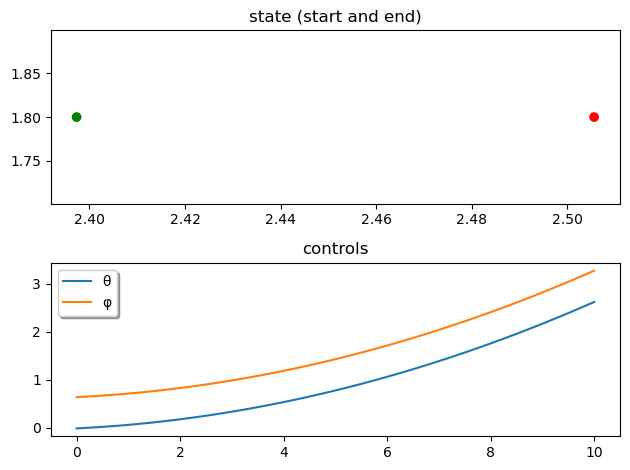

In [7]:
alpha1, alpha3, alpha4 = 1, (5*π/180), (5*π/180)
endscale = 1 # lambda
l1, l2 = 1, 1
targety = 1.8
targetx = 3
beta = 0.63598
l3 = 1.8

def ode(t, y):
    """
    ind   0  1  2  3  4  5   6   7   8   9
        ([x, y, θ, φ, ψ, dθ, dφ, p1, p2, p3])'
    """
    n = len(y[0])
    #initialize the lagrange mults for the ineq. constraints
    mu3, mu4 = np.ones((2, n))
    mu1, mu2  = np.ones((2, n))

    # use complemmentary slackness
    mask = y[3]-y[2] == 0
    mu1[~mask] = 0
    mask = -π/2+y[2]-y[3] == 0
    mu2[~mask] = 0
    mask = -π/18 - y[2] == 0
    mu3[~mask] = 0
    mask = -π/2 + y[2] == 0
    mu4[~mask] = 0
    
    #pre allocate some of the variables
    dx, dy = np.zeros(n), np.zeros(n)
    dtheta = np.zeros(n)
    dphi = np.zeros(n)

    #check whether each leg is on the ground
    cond1 = y[1]-(l1*np.cos(y[2])+l2*np.cos(y[3])) <= 0
    val = mu1 - mu2 + mu3 - mu4
    #define how the control evolves
    dtheta[cond1] = -np.log((y[7][cond1]*l1*np.sin(y[2][cond1])-y[8][cond1]*l1*np.cos(y[2][cond1])))+np.log((-2*(alpha3)**-1*y[2][cond1]+val[cond1]))
    dtheta[~cond1] = np.log(alpha3)
    dphi[cond1] = -np.log((y[7][cond1]*l2*np.sin(y[3][cond1])-y[8][cond1]*l2*np.cos(y[3][cond1])))+np.log((-2*(alpha4)**-1*y[3][cond1]-mu1[cond1]+mu2[cond1]))
    dphi[~cond1] = np.log(alpha4)
    dtheta = np.exp(dtheta)
    dphi = np.exp(dphi)

    # define different parts of the state evolution
    dx[cond1] = l2*dphi[cond1]*np.cos(y[3][cond1]) + l1*dtheta[cond1]*np.cos(y[2][cond1])
    dx[~cond1] = l3*alpha3*np.cos(y[4][~cond1])
    dy[cond1] = (l2*dphi[cond1]*np.sin(y[3][cond1]) + l1*dtheta[cond1]*np.sin(y[2][cond1]))
    dx[~cond1] = l3*alpha3*np.sin(y[4][~cond1])
    
    p3 = y[7]*(-l3*alpha3**2*np.sin(y[4]))+y[8]*(-l3*alpha3**2*np.sin(y[4]))
    
    return np.array([dx, dy, y[5], y[6], alpha3*np.ones(n), dtheta, dphi, np.zeros(n), 4*(alpha1**-1*(y[1]-targety))**3, p3])

#define the boundary conditions
def bc(ya, yb):
    """
    ind   0  1  2  3  4  5   6   7   8   9
        ([x, y, θ, φ, ψ, dθ, dφ, p1, p2, p3])'
    """
    return np.array([ya[2], ya[3]-π/6, ya[4]+π/4, ya[5]-alpha3, ya[6]-alpha3, yb[0]-targetx, yb[1]-targety, yb[7]+2*endscale*targetx, yb[8], yb[9]])


#use solve bvp to get a solution
y0 = np.ones((10,n))
y0[0] = np.linspace(-1, 1, n)
y0[1] = y0[1]*1.8
y0[2] = y0[2]*-π/90
y0[4] = np.linspace(-π/4, π/4, n)
domain = np.linspace(0, 8, n)
# p0 = np.array([6]) #try optimizing over tf later
sol = solve_bvp(ode, bc, domain, y0, max_nodes=30000, tol=1e-6)

n = len(sol.y[0])
domain = np.linspace(0, 10, n)
plt.subplot(211)
plt.title('state (start and end)')
plt.scatter([sol.y[0][0], sol.y[0][-1]], [sol.y[1][0], sol.y[1][-1]], c=['g', 'r'])
plt.subplot(212)
plt.title('controls')
plt.plot(domain, sol.y[2], label = 'θ')
plt.plot(domain, sol.y[3], label = 'φ')
plt.legend(fancybox=True, shadow=True)
plt.tight_layout()
plt.show(block=True)

What is interesting in the above results is it does seem to be pretty good for one step, the control seems to evolve a little more naturally and the state begins and ends where we want it. This might be due to forced behavior and further development is needed before we actually use this model.

## 3 Results

<p align="center">
  <img src="mediafolder/kneels.gif" alt="Stick Fig" width="400"/><img src="mediafolder/instability.gif" alt="Stick Fig" width="400"/>
</p>
As seen on the figure above, the initial results were less than desirable. We struggled with numerical instability and overflow represented on the right animation above.  We also found it difficult to motivate movement in the y-axis as shown by the figure on the left.  The model went through many iterations before we found a stable one. In order to get rid of overflow we used a logarithm to split some divisions and then exponentiated the results.  This worked suprising well and we started to see smooth/understandable results.  Unfortunately in all of our experiments we did not succeed in getting the model to 'walk.' This is discussed further in the analysis section.  Note the next two figures:

<p align="center">
  <img src="mediafolder/badstand.gif" alt="Stick Fig" width="400"/><img src="mediafolder/Figure_1.png" alt="Stick Fig" width="400"/>
</p>
<p align="center">
  <img src="mediafolder/badstand2.gif" alt="Stick Fig" width="400"/><img src="mediafolder/Figure_2.png" alt="Stick Fig" width="400"/>
</p>

Each of the solutions above were solved with a different ODE.  One was solved using the bang-bang solution for the derivatives and the analytical solution for the rest of the control as seen above (ode2 in code). The second one was solved by solving for the control using the ODEs found above (ode3 in code).  This is important as it suggests that the analytical solutions and bang-bang switching times found are correct since a numerical solver gave the same control (see the plots of the control to the right).  It also suggests that our stable code implementation is working as desired and the flaw in our project is a problem with our state or cost functional we chose.  While this is still disappointing, it does help clue us in to what precisely is wrong and how future iterations can be improved.


<p align="center">
  <img src="mediafolder/yoga.gif" alt="Stick Fig" width="400"/><img src="mediafolder/controls(yoga).png" alt="Stick Fig" width="400"/>
</p>
<p align="center">
  <img src="mediafolder/kneelskinda.gif" alt="Stick Fig" width="400"/><img src="mediafolder/controls(kneelskinda).png" alt="Stick Fig" width="400"/>
</p>

The above two figures tell us more about some issues we might be having.  The top figure demonstrates that depending on the conditions the inequality strengths are not costly enough to be enforced.  In the lower figure the model finds some floating equilibrium where it's not standing on 0 as we desire, but lower. This suggests that the state is not evolving properly in the y direction--the velocity in y is somehow negative even though the conditions for the feet to be on the ground are cleared.

## 4 Analysis
Due to the complicated nature of the problem, our model currently does not produce the desired result when solving the ODEs via Python. One major problem we have identified is defining the evolution of the control when the foot is not on the ground.

With continual improvements to one of the many parameters of the problem, we foresee potential success with this project. For example, one improvement that can be made is changing the ODE that was derived from the cost functions and state equations by making minor changes to the behavior of the cost function or state. One other improvement would be to solve for one step and then feed the final conditions of taking one step into the initial conditions of the next step, thereby discretizing the walk. Another iteration of this system could include treating each leg as an inverted double pendulum when it is in contact with the ground, and a regular double pendulum when not on the ground.  This would include increasing the state to track the position of both feet. We started working on this but the complexity of adding such a feature would possibly double the amount of work we have already put in and thus we did not have time to try it. 

## 5 Conclusion
The optimization of physical systems can become extremely difficult. Abstracting real world physics into mathematical rules motivated by cost is helpful in order to make this problem solvable in the context of our curriculum.  At the same time it is hurtful as we have to guess the lagrange multipliers aka guessing the importance of certain behaviors. Future iterations of this project could possibly redefine the state equation to help motivate 'natural' movement while a leg is not on the ground. It would also likely prove beneficial to refine the parameters and the cost function, such as adding a cost for holding a leg in the air for too long. In addition to fixing the models interactions with the floor we foresee these changes providing a model closer to the desired outcome.

## References
1. Friston, Karl. <i>What Is Optimal about Motor Control?<i> Neuron, vol. 72, no. 3, Nov. 2011, pp. 488–98. ScienceDirect, https://doi.org/10.1016/j.neuron.2011.10.018.
2. Humpherys, J., Jarvis, T., & Whitehead, J. (2024). <i>Foundations of Applied Mathematics, Volume 4, Modeling with Dynamics and Control</i>
3. Koch, M. W., et al. <i>Discrete Mechanics and Optimal Control of Walking Gaits.<i> Journal of Computational and Nonlinear Dynamics, vol. 12, no. 021006, Dec. 2016. Silverchair, https://doi.org/10.1115/1.4035213.
4. Weng, Jiacheng, et al. <i>Adaptive Reference Inverse Optimal Control for Natural Walking With Musculoskeletal Models.<i> IEEE Transactions on Neural Systems and Rehabilitation Engineering, vol. 30, 2022, pp. 1567–75. IEEE Xplore, https://doi.org/10.1109/TNSRE.2022.3180690.
5. <i>Biped Motor Control</i>. (2024). GitHub Repository. https://github.com/AddisonFP/Biped-Motor-Control/blob/main/JaAdLiTy.py